# Multi-TX/TL

Matthieu Kratz

## Why this model?

Like most genetic circuit models, you typically start with a model that captures the two fundamental processes of transcription and translation. These processes can modelled with varying degrees of complexity, ranging from a basic tx/tl model (__Equation 1__) to complex models that simulate tx/tl at a base pair level. For my project, it was of particular importance that I accurately model the sequestration of transcriptional machinery. Further, I was working without RPU data, making typical models that assume some maximum steady state saturation e.g. positive proportional hill intractable for my system. 

\begin{align}
\\ \\
&G \xrightarrow{ktx} T + G \\ \\ 
&\textbf{Equation 1.} \ \ \text{Simple Transcription}
\\
\end{align}



Hence, I needed a model that gave reasonable steady state transcription and translation dynamics from non-RPU parameters, all while accurately tracking the sequestration of the relevant machinery. 

## The Multi-TX Model

The model CRN is below and the mechanism effectively relies on accounting for all possible RNAp occupancy states, including the various transitions between these occupancy states.

\begin{align}
\\ \\
&\textbf{1. Binding} \\ 
&T7_p + T7_p:G_n  \underset{kT72}{\overset{kT71}\rightleftharpoons} T7_p:G_{n\alpha}  \ \ , \   \text{n $\neq$ $n_{max}$} \\ \\
&\textbf{2. Closed --> Open} \\ 
&T7_p:G_{n\alpha}  \xrightarrow{k_{iso}} T7_p:G_{n+1}  \ \ , \   \text{n $\neq$ $n_{max}$} \\ \\
&\textbf{3. TX} \\ 
&T7_p:G_{n\alpha} \xrightarrow{ktx} nT7_m + nT7_p + T7_p:G_{0\alpha} \ \ , \  \text{n $\neq$ 0} \\ 
&T7_p:G_n \xrightarrow{ktx} nT7_m + nT7_p + T7_p:G_{0} \ \ , \  \text{n $\neq$ 0} \\
\end{align}

kT71 --> Promoter binding rate constant (bimolecular)

kT72 --> Promoter unbinding rate constant (unimolecular)

k_iso --> Closed to open complex transition rate constant (unimolecular)

ktx --> Single polymerase mRNA synthesis rate constant (unimolecular)

A couple of comments:
- We explicitly model the process of transitioning from the closed ($T7_p:G_{n\alpha}$) to open complex ($T7_p:G_{n+1}$). This a pretty slow reaction in vivo, and in the various iterations of this model, including this seemed to be key in accurately reflecting transcription dynamics.

- $n_{max}$ refers to the maximum possible occupancy of the gene. This is the physical limit which is ultimately determined by the footprint of the polymerase and the length of the gene. In relation to the point above, without isomerization, this physical limit is always met. With the explicit isomerization, this physical saturation is not met (with my parameter set at least).

- Polymerase can only be added one at a time to existing genes i.e. cannot have multiple binding events or closed complexes simultaneously.

- We have two TX reactions, one from the closed state and the other from the open state, both with $N$ actively transcribing polymerases. We decided to allow release from the closed state as there is no reason why one polymerase in the closed form should inhibit of other activitely transcribing polymerases. Further, at a modelling level, not allowing release from the closed state results in excessive sequestration of polymerase due to the long time scale of isomerization.

- In both TX reactions, the entirety of the $N$ polymerases (bar the one in the closed state) are simultaneously release, along with $N$ transcripts and the unoccupied gene ($T7_p:G_{0}$)

## Biocrnpyler multi_tx Mechanism subclass

Subclass should be availabe via `from biocrnpyler import mechanism`, code is below for clarity

Couple of comments:
- The subclass has been designed to be used in concert with the Promoter and DNA assemblies subclasses

- Have to define a maximum occupancy (int) and cognate polymerase (species or str) when instantiating 

- The various complex species are generated within the subclass from the names of the polymerase and dna objects in the DNAassembly object. They are defined as species with DNA material types.
    

## Example: T7 Polymerase Transcription of GFP mRNA

Now we define a DNA assembly that use our mechanism in the following steps:
- Create a species for the relevant polymerase
- Create multi_tx Mechanism, give a maximum occupancy and polymerase (must be species)
- Associate this mechanism with a promoter
- Place this promoter into a DNA assembly

And voila, the cassette regulated by T7p is ready to use!

This DNAassembly will be placed in a SimpleTxTlExtract which only dilutes mRNA, not proteins. I haven't used protein dilution as it makes it easier to glean the degree of sequestration present with this mechanism. In practical use, you would of course allow your polymerase to be diluted.

In [1]:
from biocrnpyler import *

# Define Polymerase, and max occupancy and instatiate Mechanism Object
T7P = Species('T7p','protein')
#Multi-tx mechanism
MX = multi_tx(pol=T7P,name='MX')

# create promoter object, associated MX and params with it
pT7_mx = Promoter(name='pT7',mechanisms={'transcription':MX})

# place promoter object into DNA assembly with GFP reporter
GFP = Species("GFP", material_type = "protein")
PFL_mx = DNAassembly('PFL', promoter=pT7_mx, rbs = "weak", protein=GFP)

# create simple promoter and DNA assembly objects that synthesize polymerase
SC = DNAassembly('T7_const', promoter="weak", rbs = "weak", protein=T7P)

# make extract with T7p source and GFP and compile CRN 
mixture = SimpleTxTlDilutionMixture(components=[PFL_mx, SC], parameter_file = "default_parameters.txt")

CRN1 = mixture.compile_crn()

print(CRN1.pretty_print(show_rates = False))
print(mixture.components)

Species (86) = {0. dna[PFL] init_conc = 0, 1. complex[dna[PFL]:protein[T7p]], 2. complex[dna[PFL]:2x_protein[T7p]], 3. complex[dna[PFL]:3x_protein[T7p]], 4. complex[dna[PFL]:4x_protein[T7p]], 5. complex[dna[PFL]:5x_protein[T7p]], 6. complex[dna[PFL]:6x_protein[T7p]], 7. complex[dna[PFL]:7x_protein[T7p]], 8. complex[dna[PFL]:8x_protein[T7p]], 9. complex[dna[PFL]:9x_protein[T7p]], 10. complex[dna[PFL]:10x_protein[T7p]], 11. complex[dna[PFL]:11x_protein[T7p]], 12. complex[dna[PFL]:12x_protein[T7p]], 13. complex[dna[PFL]:13x_protein[T7p]], 14. complex[dna[PFL]:14x_protein[T7p]], 15. complex[dna[PFL]:15x_protein[T7p]], 16. complex[dna[PFL]:16x_protein[T7p]], 17. complex[dna[PFL]:17x_protein[T7p]], 18. complex[dna[PFL]:18x_protein[T7p]], 19. complex[dna[PFL]:19x_protein[T7p]], 20. complex[dna[PFL]:20x_protein[T7p]], 21. complex[dna[PFL]:21x_protein[T7p]], 22. complex[dna[PFL]:22x_protein[T7p]], 23. complex[dna[PFL]:23x_protein[T7p]], 24. complex[dna[PFL]:24x_protein[T7p]], 25. complex[dna[PF

C:\ProgramData\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


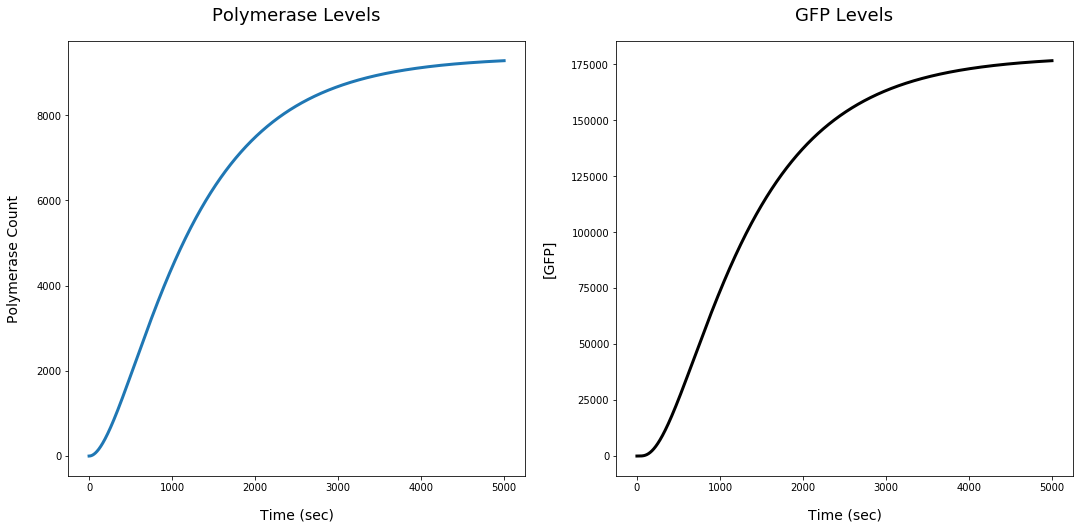

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ts = np.arange(0,5000,1)

x0_dict = {repr(PFL_mx.dna):1.,repr(SC.dna):.1}

R1 = CRN1.simulate_with_bioscrape_via_sbml(ts, initial_condition_dict = x0_dict, stochastic = False)
if R1 is not None:
    fig, ax = plt.subplots(1,2,figsize=(18,8))
    ax[0].set_title('Polymerase Levels',pad=20,fontdict={'fontsize':18})
    ax[0].plot(R1[str(T7P)],linewidth=3)
    ax[0].set_xlabel('Time (sec)',labelpad=15,fontdict={'fontsize':14})
    ax[0].set_ylabel('Polymerase Count',labelpad=15,fontdict={'fontsize':14})

    ax[1].set_title('GFP Levels',pad=20,fontdict={'fontsize':18})
    ax[1].plot(R1[str(GFP)],linewidth=3,c='k')
    ax[1].set_xlabel('Time (sec)',labelpad=15,fontdict={'fontsize':14})
    ax[1].set_ylabel('[GFP]',labelpad=15,fontdict={'fontsize':14})


## Comparison of Transcript SS with RPU Data

Here we will do a head to head comparison with a simple transcription model built using RPU data. I consider this to effectively be the ground truth for the SS Transcript Count, although it should be noted this comparison does not necessary validate any of the pre-SS dynamics as the simple transcription model assumes immediate saturation. RPU data is from Qi et al.(2012) and RPU standard is from supplement of Nielsen et al. (2016).

In [3]:
# place promoter object into DNA assembly
mech_default = Transcription_MM(rnap=T7P,name='MX')
pT7 = Promoter("pT7", mechanisms = [mech_default])
PFL_default = DNAassembly('PFL',dna='T7',promoter=pT7,rbs = "weak", protein = GFP)

# make extract with T7p source and GFP and compile CRN 
Test_EX = SimpleTxTlDilutionMixture(components=[PFL_default, SC],parameter_file = "default_parameters.txt")
CRN2 = Test_EX.compile_crn()


 

MX Model predicts 176671.0 GFP and RPU Model predicts 24740.0 GFP at SS 
 



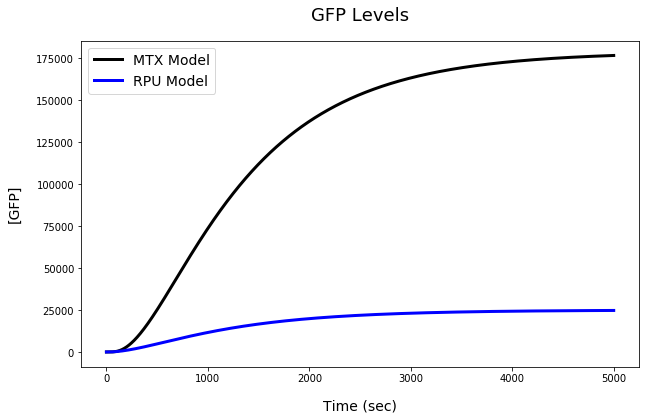

In [4]:
import numpy as np
import matplotlib.pyplot as plt

ts = np.arange(0,5000,1)
x0_dict = {repr(PFL_default.dna):1, repr(SC.dna):.1}

R2 = CRN2.simulate_with_bioscrape_via_sbml(ts, initial_condition_dict = x0_dict, stochastic = False,)
if R2 is not None:
    fig = plt.figure(figsize=(10,6))
    plt.title('GFP Levels',pad=20,fontdict={'fontsize':18})
    plt.plot(R1[str(GFP)],linewidth=3,c='k',label='MTX Model')
    plt.plot(R2[str(GFP)],linewidth=3,c='b', label='RPU Model')
    plt.xlabel('Time (sec)',labelpad=15,fontdict={'fontsize':14})
    plt.ylabel('[GFP]',labelpad=15,fontdict={'fontsize':14})
    plt.legend(fontsize=14)

    print('\n \n')
    print(f"MX Model predicts {np.round(R1[str(str(GFP))].iloc[-1])} GFP and RPU Model predicts {np.round(R2[str(str(GFP))].iloc[-1])} GFP at SS \n \n")


The two models seem to agree pretty well, with some minor difference. This is pretty cool given the fact that MX model uses indirect parameters (promoter affinity, isomerization and tx rates) to predict this SS value. Of course, it's also important to keep in mind that alternative models typically do to not account for the constant sequestration of the polymerase machinery to sustain this SS transcript level. As such, they may not reflect key dynamics resulting from machinery allocation/sharing e.g. retroactivity in tx/tl.

## Putative Multi-TL Model

The general model of binding, isomerization and production can be readily extended to the process of translation. However, there are several caveats for translation. 

- First of all, I don't have any direct data like RPU experiments to compare my model with. All I can say is that with biologically reasonable parameter sets, you get something like a few 100 proteins per mRNA (RBZ in excess) and e. coli has a protein to mRNA ratio in that range (100:1 - 1000:1) (Taniguchi et al.(2010) or bionumbers book). 

- Second of all, since we're no longer working with DNA complexes, the mRNA-RBZ complexes should be subject to degredation/dilution. However, it seems that at the level of the biology, initiation can have a stabilizing effect and for elongation it is uncertain (Roy et al. (2013)). In my simulations, I've effectively done as if only dilution is applied to these complexes, but there is an argument to include some form of active degredation (at a reduced rate). Depending on how this implemented, one may need to make a new degredation mechanism where the complexes effectively releases the ribosomes i.e. only mRNA degraded. This is also complicated by the fact that using subclasses like ComplexSpecies() results in inheritance of degredation/material properties. 

## Quick Example 
PFL is transcribed through simple transcription and translated through my multi_tl mechanism. We also have a constitutive source of our RBZ being produced to provide a constant saturating concentration of RBZ.

In [5]:
#extra parameters not in the file
parameters = {"max_occ":2, "kbr":100, "kur":10, "k_iso_r":10, "ktl_solo":.01}

#Create a DNA assembly and Mixture
PFL = DNAassembly('PFL', dna='T7', rbs='medium', promoter='medium',transcript='GFP',protein='GFP')
EM = TxTlDilutionMixture(name = 'e coli',components=[PFL], parameter_file = "default_parameters.txt", parameters = parameters)

# Instantiate mechanism and pass it the ribosome
ML = multi_tl(EM.ribosome.get_species())

#Overwrite the translation mechanism
EM.add_mechanism(ML, overwrite = True)

CRN3 = EM.compile_crn()
print(CRN3.pretty_print(show_rates = True))

Species (21) = {0. dna[T7] init_conc = 0, 1. protein[RNAP(machinery)] init_conc = 0, 2. rna[GFP] init_conc = 0, 3. complex[dna[T7]:protein[RNAP]], 4. complex[protein[Ribo]:rna[GFP]], 5. complex[2x_protein[Ribo]:rna[GFP]], 6. complex[protein[Ribo]:rna[GFP](closed)], 7. complex[2x_protein[Ribo]:rna[GFP](closed)], 8. protein[Ribo(machinery)] init_conc = 0, 9. protein[GFP] init_conc = 0, 10. protein[RNAase(machinery)] init_conc = 0, 11. complex[protein[RNAase]:rna[GFP]], 12. dna[cellular_processes] init_conc = 0, 13. rna[cellular_processes] init_conc = 0, 14. complex[dna[cellular_processes]:protein[RNAP]], 15. complex[protein[Ribo]:rna[cellular_processes]], 16. complex[2x_protein[Ribo]:rna[cellular_processes]], 17. complex[protein[Ribo]:rna[cellular_processes](closed)], 18. complex[2x_protein[Ribo]:rna[cellular_processes](closed)], 19. protein[cellular_processes] init_conc = 0, 20. complex[protein[RNAase]:rna[cellular_processes]]}

Reactions (30) = [
0. dna[T7]+protein[RNAP(machinery)] <--

C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\mechanisms_txtl.py:462: UserWarning: This mechanism still needs some extra validation, use at your own peril and read the warnings!
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\mechanisms_txtl.py:463: UserWarning: To properly use this mechanism, set dilution for mRNA-RBZ complexes!
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\mechanisms_txtl.py:464: UserWarning: I've set RBZ and mRNA-RBZ complexes as protein Species to apply dilution to them, edit if you want something else!


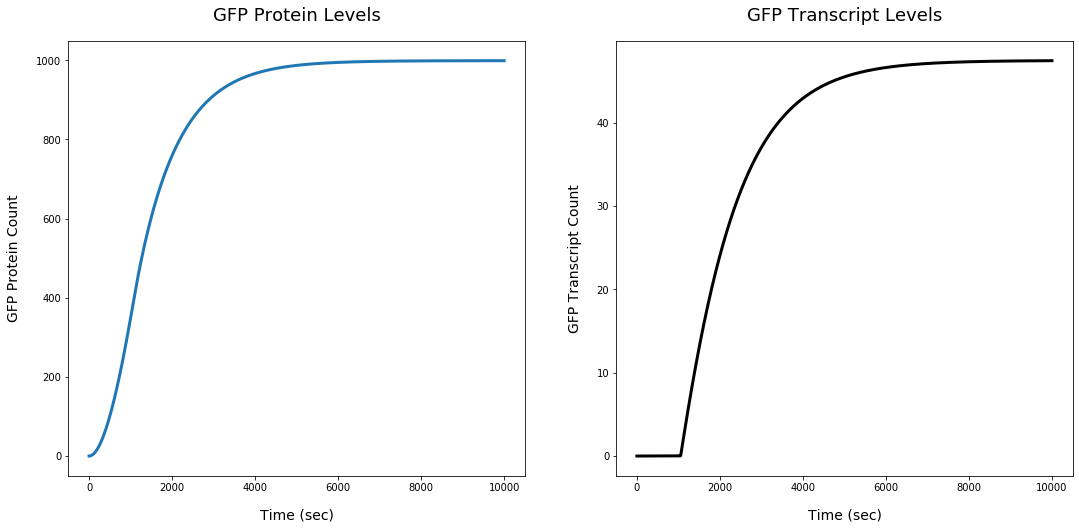

In [8]:
import numpy as np
import matplotlib.pyplot as plt

ts = np.arange(0,10000,1)
x0_dict = {repr(PFL.dna):1, repr(EM.ribosome.get_species()):100,  repr(EM.rnap.get_species()):20}

R3 = CRN3.simulate_with_bioscrape_via_sbml(ts, initial_condition_dict = x0_dict, stochastic = False,)

if R3 is not None:
    fig, ax = plt.subplots(1,2,figsize=(18,8))
    ax[0].set_title('GFP Protein Levels',pad=20,fontdict={'fontsize':18})
    ax[0].plot(R3[str(PFL.protein)],linewidth=3)
    #ax[0].plot(R3[str(EM.ribosome.get_species())],linewidth=3)
    ax[0].set_xlabel('Time (sec)',labelpad=15,fontdict={'fontsize':14})
    ax[0].set_ylabel('GFP Protein Count',labelpad=15,fontdict={'fontsize':14})

    ax[1].set_title('GFP Transcript Levels',pad=20,fontdict={'fontsize':18})
    ax[1].plot(R3[str(PFL.transcript)],linewidth=3,c='k')
    ax[1].set_xlabel('Time (sec)',labelpad=15,fontdict={'fontsize':14})
    ax[1].set_ylabel('GFP Transcript Count',labelpad=15,fontdict={'fontsize':14})


# Future Work

- Want to do more rigorous validation of multi-tx mechanism. As part of that, I first plan on comparing RPU data of existing consitutive promoters and non-native polymerase expression systems e.g. T5 with what the multi-tx model would predict. 
- Is there data out there that would help validate the predicted RNAp occupancy of genes from the multi-tx model (same story for multi-tl model)?
- Eventually want to develop a multi-tx mechanism that can be used for TF-mediated transcription.
- Start looking towards validating multi-tl model, currently plan on seeing what data and parameters I could scrape from existing resource e.g. BCD RBS binding rates from biocrnpyler. 
- Do some model comparison using bioscrape inference, where I generate parameters with RPU data model and fit parameters (vary known and unknown parameters) from the MTX model. Definitely very interesting for deriving isomerization rates as that seems hard to come by in literature and seems to be a key part of the model in determining system behaviour (Pre-SS and SS dynamics).

# Mentioned Papers and Parameter Resources

T7 parameters:
- Promoter Binding and Unbinding: Jia, Y., Kumar, A., & Patel, S. S. (1996). Equilibrium and Stopped-flow Kinetic Studies of Interaction between T7 RNA Polymerase and Its Promoters Measured by Protein and 2-Aminopurine Fluorescence Changes. Journal of Biological Chemistry , 271(48), 30451–30458. https://doi.org/10.1074/jbc.271.48.30451 
- Isomerization Rate: Skinner, G. M., Baumann, C. G., Quinn, D. M., Molloy, J. E., & Hoggett, J. G. (2004). Promoter Binding, Initiation, and Elongation By Bacteriophage T7 RNA Polymerase: A SINGLE-MOLECULE VIEW OF THE TRANSCRIPTION CYCLE . Journal of Biological Chemistry , 279(5), 3239–3244. https://doi.org/10.1074/jbc.M310471200 
- Translation Rate (T7p is VERY fast): Kochetkov, S. N., Rusakova, E. E., & Tunitskaya, V. L. (1998). Recent studies of T7 RNA polymerase mechanism. FEBS Letters, 440(3), 264–267. https://doi.org/https://doi.org/10.1016/S0014-5793(98)01484-7
   
Translation Parameters:
- RBS Binding and Unbinding: Chandra, F., & Del Vecchio, D. (2016). The Effects of Ribosome Autocatalysis and Negative Feedback in Resource Competition. bioRxiv. https://doi.org/10.1101/042127
- Isomerization Rate: Draper, D. E. (1993). Mechanisms of Translational Initiation and Repression in Prokaryotes BT  - The Translational Apparatus: Structure, Function, Regulation, Evolution. In K. H. Nierhaus, F. Franceschi, A. R. Subramanian, V. A. Erdmann, & B. Wittmann-Liebold (Eds.) (pp. 197–207). Boston, MA: Springer US. https://doi.org/10.1007/978-1-4615-2407-6_19

Misc:
- mRNA Degredation: Roy, B., & Jacobson, A. (2013). The intimate relationships of mRNA decay and translation. Trends in Genetics : TIG, 29(12), 691–699. https://doi.org/10.1016/j.tig.2013.09.002
- RPU Data: Nielsen, A. A. K., Der, B. S., Shin, J., Vaidyanathan, P., Paralanov, V., Strychalski, E. A., … Voigt, C. A. (2016). Genetic circuit design automation. Science, 352(6281), aac7341. https://doi.org/10.1126/science.aac7341 and Qi, L., Haurwitz, R. E., Shao, W., Doudna, J. A., & Arkin, A. P. (2012). RNA processing enables predictable programming of gene expression. Nature Biotechnology, 30(10), 1002–1006. https://doi.org/10.1038/nbt.2355
- Protein:mRNA ratios: Taniguchi, Y., Choi, P. J., Li, G.-W., Chen, H., Babu, M., Hearn, J., … Xie, X. S. (2010). Quantifying E. coli Proteome and Transcriptome with Single-Molecule Sensitivity in Single Cells. Science, 329(5991), 533 LP – 538. https://doi.org/10.1126/science.1188308
    